## Introduction

This tutorial will introduce you to some basic methods for text classification using the Torchtext library from Pytorch. Text classification, or Natural Language processing in general, is an important domain in Data Science because it helps to resolve ambiguity in language and adds useful numeric structure to the data for many downstream applications. With NLP, Data Science aims to teach machines the underlying sense of human language. There are many tasks in the NLP domain such as speech recognition, speech to text conversion, sarcasm detection etc. For this tutorial, we will focus on sentiment analysis of tweets extracted from twitter. 

### Tutorial content

In this tutorial, we will show how to do some basic text analysis in Python, specifically using [Pytorch](https://pytorch.org/).

We'll be using dataset from this Kaggle challenge: https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading data](#Loading-data)
- [Building Vocab and DataLoader](#Building-Vocab-and-DataLoader)
- [Recurrent Neural Networks and Model Architecture](#Recurrent-Neural-Networks-and-Model-Architecture)
- [Train and evaluate](#Train-and-evaluate)
- [Visualizations](#Visualizations)
- [Summary and References](#Summary-and-References)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install Pytorch and torchtext using `pip`:
   
    $ pip install pytorch
    
    $ pip install torchtext
    
Note that there are various verisons of torchtext each having different compatibile Python versions. In order to use the latest update of torchtext, Python 3.6+ is required.

The other libraries like torch.nn, torch.optim will be automatically installed as a dependency of Pytorch

In order to utilize different types of tokenizer which are used in torchtext library (will be explained later in detail), we need to install optional requirements (used in this tutorial) using `pip` and `python`:

    $ pip install spacy
    
    $ python -m spacy download en_core_web_sm

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import *
from torchtext.legacy import data
warnings.filterwarnings("ignore")

## Loading data

Now that we've installed and loaded the libraries, let's load our twitter sentiment analysis data.  We're going to load data provided in the "csv" format using the pandas library. This is done just to explore the dataset before we start buidling models. 

For this tutorial propose, we will only be using the 'train.csv' which can be downloaded from https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv.

The objective of this tutorial is to detect hate speech in tweets. In simple words, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, the objective is to predict the positive/negative sentiment on the  validation dataset.

In [2]:
dataset=pd.read_csv('train.csv')

dataset.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Here, the id is the tweet_id and is of no use for the purpose of this tutorial. The label field is the classification label suggesting whether a particular field is a hated speech or otherwise. The tweet is the actual tweet which is being classified.

Now, lets preprocess and make this dataset ready to be used by Pytorch models. For tutorial, we will be using the torchtext library from pytorch.

**TorchText** is a Natural Language Processing (NLP) library in PyTorch. This library contains the scripts for preprocessing text and source of few popular NLP datasets and this imported using 

`from torchtext.legacy import data`

Let us see how to use the Field objects for preprocessing the data using the Torchtext library. There are two types of field objects namely - Field and LabeLField. 

**Field** = This object from legacy.data module is used to specify the preprocessing steps for the independent columns.For this tutorial, it will be used for the `tweet` column. 

**LabelField** = LabelField object is a special case of Field object which is used only for the classification tasks. Its only use is to set the unk_token and sequential to None by default.

Before we use Field, let us look at the different parameters of Field and what are they used for.

**Parameters of Field:**

**Tokenize:** specifies the way of tokenizing the sentence i.e. converting sentence to words. We will be using the `spacy` tokenizer which is the most common English tokenizer. Alternatively, we can also use the Moses tokenizer and details about these will be included in the references.

**Lower:** converts text to lowercase

**batch_first:** The first dimension of input and output is always batch size

In [3]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

Now, we will be `TabularDataset` module which will be very useful for loading the custom dataset by providing the field objects for each column. 

In order to use this, we need to create a list of tuples wherein each tuple specify the column_name (in string) and the field type. For example, ('text', Text).

To ignore some columns, like id in our case, the tuple should be (None,None).

In [4]:
#Creationg fields and Tabulardataset
fields = [(None,None),('label', LABEL),('text',TEXT)] #corresponding to id,label,text columns
alldata=data.TabularDataset(path = 'train.csv',format = 'csv',fields = fields,skip_header = True)

#To print the preprocessed text
print(vars(alldata.examples[0]))

{'label': '0', 'text': [' ', '@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '  ', '#', 'run']}


As we can see that, `TabularDataset` will make a dictionary for each datapoint with the column names as the key. This is very useful as it retrieve elements in constant complexity. 

We will now split the dataset into training and validation sets using the `TabularDFataset.split` function. This validation set will be used to evaluate the performance of the model at the end of this tutorial.

In [5]:
#splitting the dataset into training and validation subsets
train_data, valid_data = alldata.split(split_ratio=0.7)

## Building Vocab and DataLoader

The next step is to build the vocabulary for the text and converting them into integer sequences. Intuitively, the vocabulary assigns the unique words to each index.

After replacing each unique word with an index, we will be creating pretrained embeddings using the **GloVe: Global Vectors for Word Representation**. 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

GloVe is trained on approximately 300 million words worth of data from wikipedia, and common crawl books. So, it would be great to use these trained embeddings for the purpose of text classification.

In [6]:
TEXT.build_vocab(train_data,min_freq=2,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
# print(TEXT.vocab.stoi) 

Size of TEXT vocabulary: 12735
Size of LABEL vocabulary: 2
[('#', 52459), (' ', 14179), ('  ', 13418), ('@user', 12178), ('!', 10034), ('.', 8473), ('the', 7071), ('to', 6865), ('i', 5129), ('a', 4496)]


The min_freq parameter in the `build_vocab` is to remove words having frequency less than that parameter and treat it as unknown. 

For this tutorial, we are using GloVe pretrained vectors. The weights for these vectors will be then initialized for the embedding layer in the model architecture. 

**DataLoader:**

Handling variable-length sequences is very important in Natural Language Processing. As each sentence or datapoint may have different number of words, we convert the variable length input sentences into same length by padding. We will look onto this more in the model architecture section.


To prepare the batches for training, we will be using BucketIterator as it will form batches in such a way that there will be minimum amount of padding required.  

In [7]:
#to check if GPU is available to be used.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 256

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

## Recurrent Neural Networks and Model Architecture

**Recurrent Neural Networks** are a family of neural networks which are specially designed for Sequence modeling, text classification and text generation. These networks are useful for handling variable input sequence length and have an internal memory that allows the previous inputs (for the same datapoint) in time to affect the subsequent predictions. More information can be found here [https://en.wikipedia.org/wiki/Recurrent_neural_network].

The **Long Short-Term Memory (LSTM)** neural network is a special variant of the RNN, which addresses some drawbacks of the vanilla RNNs. The RNNs suffer from bottleneck stability like vanishing gradients and have less memory retention properties. 

The LSTM cell contains three gates: input gate, output gate, and the forget gate which help the network to regulate the flow of information.  A separate memory cell represent by c, is maintained in LSTMs which help for longer memory retention. The LSTMs regulates the information by selectively adding information (input gate), removing (forget gate) or letting it to the next cell (output gate).

This arrangement of gates and selective information control is also the key reason why LSTMs do not suffer from the vanishing gradient problem which plagued traditional RNNs. As a result, LSTMs are a powerful tool to model sequential datasets.

![LSTM cell architecture](LSTM.PNG)

**Model Architecture**

In this section, we will explain the different layers required to design the forward pass of the network, necesssary for Text classification using Pytorch. 


**Embedding Layer:** Embeddings are an essential component for any NLP related tasks. As seen earlier, we convert the words into a numeric format wherein each unique word is assigned an index. However, we cannot use these numeric representations directly. If we convert these into one-hot encoding, then the input dimensional space we will huge. Embedding layers creates a look up take and converts the integer sequences into a dense vector representations. There are two important parameters for this layer:
    1. vocab_size: Vocabulary size or number of unique words.
    2. embedding_size: Size of the dense representations (Hyper-parameter)
  
  
**Pack Padding:** Padding is required to the variable input size of the sequences. However, the input now possessess paddings which are treated as a piece of information and can mislead the models to predict some noise. Packed paddings ignores the input timesteps with a padding token. These values are never shown to the RNNs which helps in buidling a dynamic Neural Network.
 
 **LSTM:** As discussed earlier, LSTM is a special variant of RNN that have longer memory retention capacity. The important parameters for this layer are as follows:
     1. input_size: Dimension of input
     2. hidden_size: Hidden layer size
     3. num_layers: Number of LSTM layers stacked 
     4. batch_first: Boolean, to see of the first dimension is batch_size or not.
     5. dropout: If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
     6. Bidirection: if True, Bi-LSTM layers are used. 
 
 
**Fully connected layer:** This layer will take the outputs of the last hidden cell from LSTM and convert it to a size of num_classes. Since, it is a Binary Classification task, output size will be one and we will apply Sigmoid activation to it.


![Model Architecture](Network.PNG)

In [8]:
class Sentiment_Analysis(nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_dim,output_dim, n_layers,bidirectional, dropout):
        super(Sentiment_Analysis,self).__init__()
        
        #Embedding layer
        self.embedding_layer = nn.Embedding(vocab_size,embedding_size)
        
        #Lstm layers
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers=n_layers, 
                           bidirectional=bidirectional, dropout=dropout,batch_first=True)
        
        #Fully_connected layer
        self.FC = nn.Linear(hidden_dim*2, output_dim)
        
        #Final activation function
        self.act = nn.Sigmoid() 
    
    def forward(self, text,text_lengths):
        
        #input will be (batch_size, sent_length)
        embed = self.embedding_layer(text) #(batch_size, sent_length, embedding_size)
        
        
        #Packed padded sequence to handle the varible sent_lengths
        packed_embed = nn.utils.rnn.pack_padded_sequence(embed, text_lengths, batch_first = True)
        
        #LSTM 
        packed_output, (hidden,cell) = self.lstm(packed_embed)# (batch_size,packed_lenghts, 2*hidden)
        
        #concat the final forward and backward hidden state 
        hidden = torch.cat((hidden[-2,:,:],hidden[-1,:,:]), dim=1)
        
        out = self.FC(hidden)
        
        #Sigmoid activation
        out = self.act(out)
        
        return out

**Initialization**: Lets initialize the model, criterion and optimizer for this tutorial.

In [9]:
vocab_size = len(TEXT.vocab)
embedding_size = 100 # needs to be 100 because pretrained weights are of size 100.
hidden_size = 128
num_classes = 1
num_layers = 2
bidirectional = True
dropout =0.2

model = Sentiment_Analysis(vocab_size,embedding_size,hidden_size,num_classes,num_layers,bidirectional, dropout)
model = model.to(device)

For the purpose of this tutorial, we will be using Adam Optimizer and Binary Cross Entropy.

SGD and Adagrad can also be used but Adam is used because it is faster. More details about this can be found on this blogpost [https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6]

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

Since, we are going to use `GloVe` pretrained models, we will initalize the embedding layer weights with these pretrained weights in the following cell. Note that, embedding size is 100 because the pretrained weights are of size (Vocab_size,100).

In [11]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding_layer.weight.data.copy_(pretrained_embeddings)
print(pretrained_embeddings.shape)

torch.Size([12735, 100])


## Train and evaluate

Now that we have design the model and hyper-parameters, its time we develop the training and evaluation function for our model. 

**Training loop:** The training loop will train the parameters of the network for each epoch and return the training accuracy and loss. 

**Evaulation loop:** The evaluation loop will validate the model on the validation set and return the validation accuracy and loss.

In [12]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = []
    epoch_acc = []
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        rounded_preds = torch.round(predictions)
    
        correct = (rounded_preds == batch.label).float() 
        acc = correct.sum() / len(correct)
          
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss.append(loss.item())  
        epoch_acc.append(acc.item())
        
    return (sum(epoch_loss)/len(epoch_loss)), (sum(epoch_acc)/len(epoch_acc))

In [13]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = []
    epoch_acc = []

    #deactivating dropout layers
    model.eval()
    
    for batch in iterator:

        #retrieve text and no. of words
        text, text_lengths = batch.text

        #convert to 1d tensor
        predictions = model(text, text_lengths).squeeze()

        #compute loss and accuracy
        loss = criterion(predictions, batch.label)
        rounded_preds = torch.round(predictions)
    
        correct = (rounded_preds == batch.label).float() 
        acc = correct.sum() / len(correct)

        #keep track of loss and accuracy
        epoch_loss.append(loss.item())  
        epoch_acc.append(acc.item())   
        
    return (sum(epoch_loss)/len(epoch_loss)), (sum(epoch_acc)/len(epoch_acc))

Now, we will write the `main function` that will train and evaluate model for 10 epochs. We will save the train and validation loss as well as accuracy for plotting the curves in the next section.

In [14]:
#Main function

if __name__ == '__main__':
    N_EPOCHS = 10
    training_loss = []
    training_accuracy = []
    
    val_loss = []
    val_accuracy = []
    
    for epoch in range(N_EPOCHS):
        print('Epoch Number : ',epoch)
        #train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        training_loss.append(train_loss)
        training_accuracy.append(train_acc)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

        #evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        val_loss.append(valid_loss)
        val_accuracy.append(valid_acc)
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        ##For readibility
        print('=='*50)   

Epoch Number :  0
	Train Loss: 0.295 | Train Acc: 91.21%
	 Val. Loss: 0.245 |  Val. Acc: 92.97%
Epoch Number :  1
	Train Loss: 0.182 | Train Acc: 93.70%
	 Val. Loss: 0.152 |  Val. Acc: 94.81%
Epoch Number :  2
	Train Loss: 0.123 | Train Acc: 95.42%
	 Val. Loss: 0.135 |  Val. Acc: 95.25%
Epoch Number :  3
	Train Loss: 0.098 | Train Acc: 96.38%
	 Val. Loss: 0.123 |  Val. Acc: 95.73%
Epoch Number :  4
	Train Loss: 0.077 | Train Acc: 97.13%
	 Val. Loss: 0.101 |  Val. Acc: 96.61%
Epoch Number :  5
	Train Loss: 0.066 | Train Acc: 97.73%
	 Val. Loss: 0.099 |  Val. Acc: 96.72%
Epoch Number :  6
	Train Loss: 0.052 | Train Acc: 98.21%
	 Val. Loss: 0.105 |  Val. Acc: 96.77%
Epoch Number :  7
	Train Loss: 0.041 | Train Acc: 98.63%
	 Val. Loss: 0.101 |  Val. Acc: 97.11%
Epoch Number :  8
	Train Loss: 0.031 | Train Acc: 98.97%
	 Val. Loss: 0.135 |  Val. Acc: 96.62%
Epoch Number :  9
	Train Loss: 0.028 | Train Acc: 99.08%
	 Val. Loss: 0.145 |  Val. Acc: 96.65%


## Visualizations

Here, we will create the loss and accuracy curves for the training and validation sets. Many visualizations can be added such as confusion matrix heat map, ROC curve etc. 

We will be using Matplotlib library

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

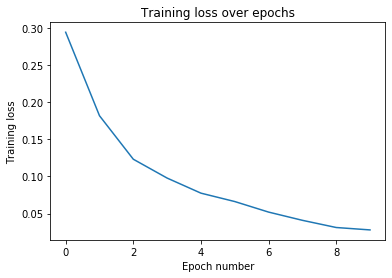

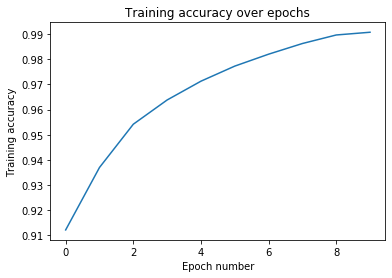

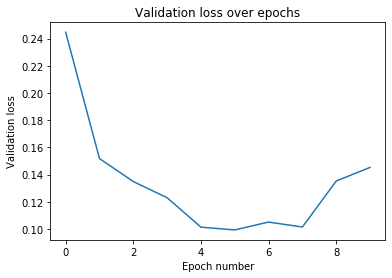

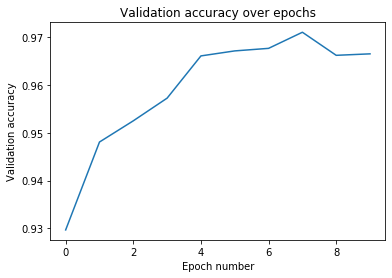

In [16]:
#Training loss graph
plt.plot(training_loss)
plt.title('Training loss over epochs')
plt.xlabel('Epoch number')
plt.ylabel('Training loss')
plt.show()

#Training acc graph
plt.plot(training_accuracy)
plt.title('Training accuracy over epochs')
plt.xlabel('Epoch number')
plt.ylabel('Training accuracy')
plt.show()

#Validation loss graph
plt.plot(val_loss)
plt.title('Validation loss over epochs')
plt.xlabel('Epoch number')
plt.ylabel('Validation loss')
plt.show()

#Validation acc graph
plt.plot(val_accuracy)
plt.title('Validation accuracy over epochs')
plt.xlabel('Epoch number')
plt.ylabel('Validation accuracy')
plt.show()

In [17]:
#model predictions:

actual_labels = []
valid_predictions= []

model.eval()
    
for batch in valid_iterator:

    #retrieve text and no. of words
    text, text_lengths = batch.text

#   #convert to 1d tensor
    predictions = model(text, text_lengths).squeeze()
    rounded_preds = torch.round(predictions)
    
    actual_labels.extend(batch.label.detach().cpu().numpy().astype(np.int8))
    valid_predictions.extend(rounded_preds.detach().cpu().numpy().astype(np.int8))
        

#Confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels,valid_predictions)

As we have only trained for five epochs, we can see that the loss curves are not monotonically decreasing always. The purpose of this tutorial was to give a basic idea about the torchtext library and training of LSTM models using Pytorch. Further, optimizing the model and fine-tuning the hyperparameters can give better results.

## Summary and References

This tutorial highlighted just a few elements of Text analysis using the Torchtext library from Pytorch. Following links provide more details about the libraries discussed here.

1. Pytorch documentation: https://pytorch.org/docs/stable/index.html
2. Pytorch tutorials: https://pytorch.org/tutorials/
3. PyTorch Tutorial for Deep Learning Researchers: https://github.com/yunjey/pytorch-tutorial
4. Torchtext Documentation: https://pytorch.org/text/stable/index.html
5. Torchtext Installation: https://pypi.org/project/torchtext/
6. LSTM : https://cnvrg.io/pytorch-lstm/
7. Twitter sentiment analysis dataset: https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv
8. Packed padded sequence: https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
9. GloVe: https://nlp.stanford.edu/projects/glove/